# Simple RGB image workflow

Made by: Anna Casto

Updated: April 16, 2023

This tutorial shows basic steps for analyzing an RGB image of a single plant. Many more options are available at each step, if needed. Some of these are illustrated in the tutorial: Single Plant RGB Image Workflow

In [1]:
import os

# Detect notebook environment
def detect_notebook_environment():
    if 'COLAB_GPU' in os.environ:
        print('Google Colaboratory detected.')
        %pip install "altair>=5" ipympl plantcv
        
        # Give access and mount your Google Drive (need a Google Account)
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        # Enable widget feature with matplotlib
        from google.colab import output
        output.enable_custom_widget_manager()
        
        #View working directory, may need to change
        %pwd
    else:
        print('Binder detected.')

environment = detect_notebook_environment()

Binder detected.


In [2]:
# If working in Binder, widget may not be functioning
# %matplotlib inline
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

#### Set workflow inputs and outputs

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./img/1_B73_sand_C_2023-04-14_10_19_07.jpg"],
    names="image",
    result="example_results.json",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

#### Edit display settings if necessary

In [4]:
pcv.params.debug = "plot"
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 10
pcv.params.text_thickness = 20

#### Read in the image. 
The path to the image was set above in the input/output options section.

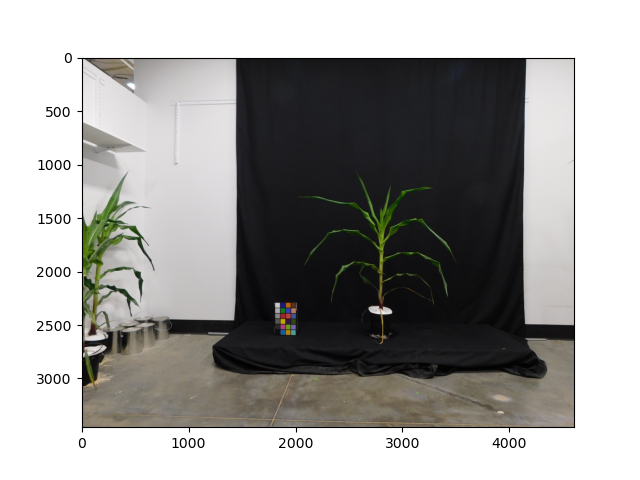

In [5]:
# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image, mode = "native")

#### Crop image if necessary. 
This is optional but can help if there are many extra objects around the object you're interested in. 

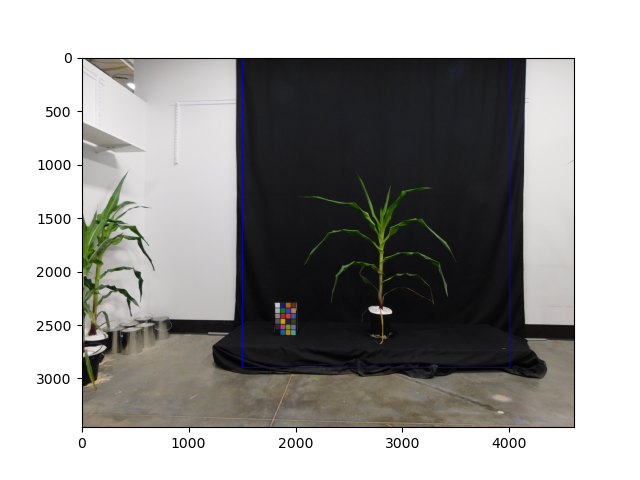

In [6]:
# Inputs:
#   img - RGB, grayscale, or hyperspectral image data 
#   x - X coordinate of the top left corner of the box to crop to
#   y - Y coordinate of the top left corner of the box to crop to
#   h - Height of the box to crop to
#   w - Width of the box to crop to

crop_img = pcv.crop(img=img, x=1500, y=0, h=2900, w=2500)

#### Optional color correction
If you have a color card in your image, you have the option to color correct your images to a reference image or to the color card standard values. Color correction isn't always necessary, but if your images had variable lighting, color correction can help with segmentation. Most importantly, color correction allows you to compare color values like hue circular mean between images when analyzing color. 
See the [Color correction tutorial](https://plantcv.readthedocs.io/en/stable/tutorials/transform_color_correction_tutorial/) or the [VIS tutorial](https://plantcv.readthedocs.io/en/stable/tutorials/vis_tutorial/) for more on color correction. 
Also see [White balance](https://plantcv.readthedocs.io/en/stable/white_balance/) for more image normalization functions.

#### The visualize.colorspaces function allows you to look at the color space options for masking. 
Choose the colorspace in which the plant is most distinct from the backgound. This is a visualization to help with the next step.

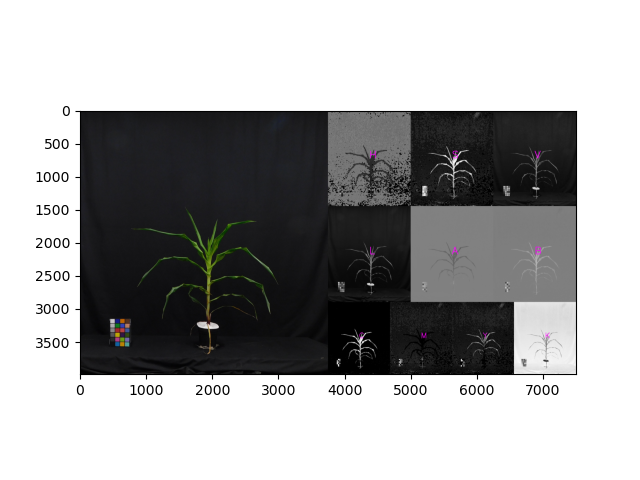

In [7]:
# Inputs:
#   rgb_img - RGB image

colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

#### Convert the RGB image to LAB and select the B channel
This step converts the RGB image to a grayscale image of a single colorspace channel. You can choose any of the above colorspaces. Be aware that the function to convert the RGB image will changed depending on your choice. 
See: [RGB to HSV](https://plantcv.readthedocs.io/en/stable/rgb2hsv/), [RGB to LAB](https://plantcv.readthedocs.io/en/stable/rgb2lab/), [RGB to CMYK](https://plantcv.readthedocs.io/en/stable/rgb2cmyk/)

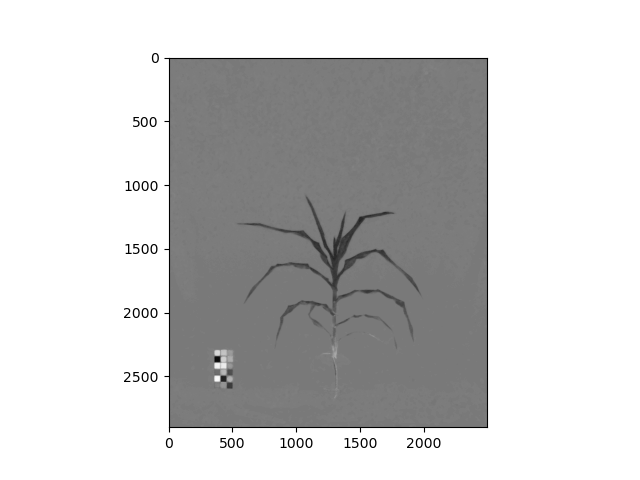

In [9]:
# Inputs:
#   rgb_img - RGB image
#   channel - colorspace channel selection (l, a, or b in this case)

b_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='a')

#### Create binary image from a gray image based on threshold values targeting light objects in the image.
Creating a histogram of the pixel intensity of the b channel image gives us an idea of what value to set the threshold to.
The histogram is for visualizatin only. It isn't needed for the analysis.

In [11]:
# Inputs:
#   img - image data
#   channel - colorspace channel selection (l, a, or b in this case)

hist_figure1, hist_data1 = pcv.visualize.histogram(img = b_img, hist_data=True)

alt.Chart(...)

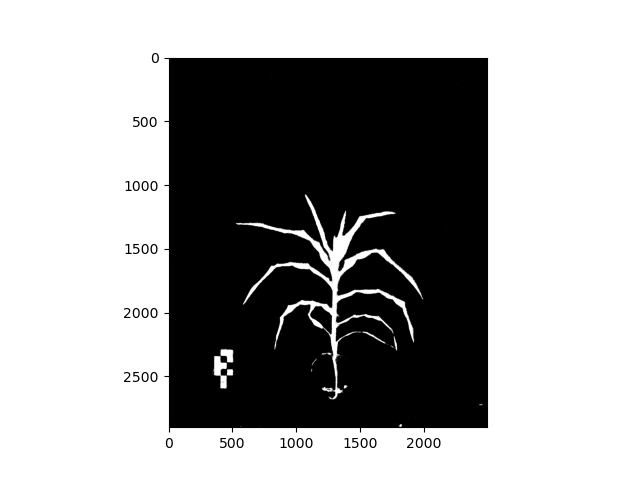

In [12]:
# Inputs:
#   gray_img - grayscale image data
#   threshold - Threshold value (0-255)
#   object_type - "light" or "dark" (default: "light"). If object is lighter than the background then standard thresholding is done. 
#                 If object is darker than the background then inverse thresholding is done.

thresh_mask = pcv.threshold.binary(gray_img=b_img, threshold=130, object_type='light')

#### Cleaning up the mask
There are several options for cleaning up and adjusting our mask ([fill](https://plantcv.readthedocs.io/en/stable/fill/#fill), [fill_holes](https://plantcv.readthedocs.io/en/stable/fill_holes/), [dilate](https://plantcv.readthedocs.io/en/stable/dilate/), [erode](https://plantcv.readthedocs.io/en/stable/erode/#erode), etc).
Here we will just use fill to fill in small objects.

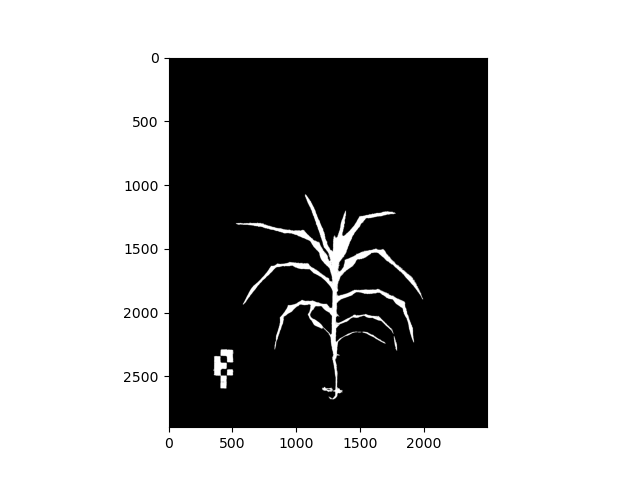

In [13]:
# Inputs:
#   bin_img - mask, binary image data
#   size - minimum object area size in pixels (integer), smaller objects will be filled


fill_mask = pcv.fill(bin_img=thresh_mask, size=1000)

#### Define the region of interest (ROI).
The ROI should include the plant but avoid the color card and other objects. 
There are many options for ROI shapes (rectangle, circle, multi, custom). Here we will just use rectangle. Be aware that you'll need to calculate the height and width of the rectangle you want with respect to the x, y coordinates of the upper left corner.

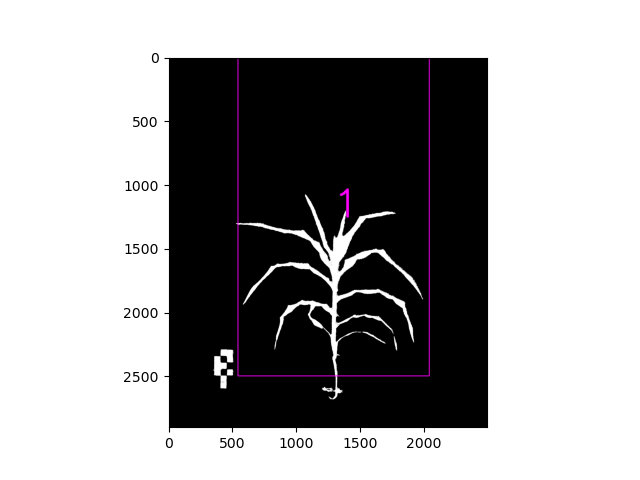

In [18]:
# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 

roi = pcv.roi.rectangle(img=fill_mask, x=540, y=0, h=2500, w=1500)

Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI.

We have set to partial here so that if a leaf extends outside of your ROI it will still be selected.


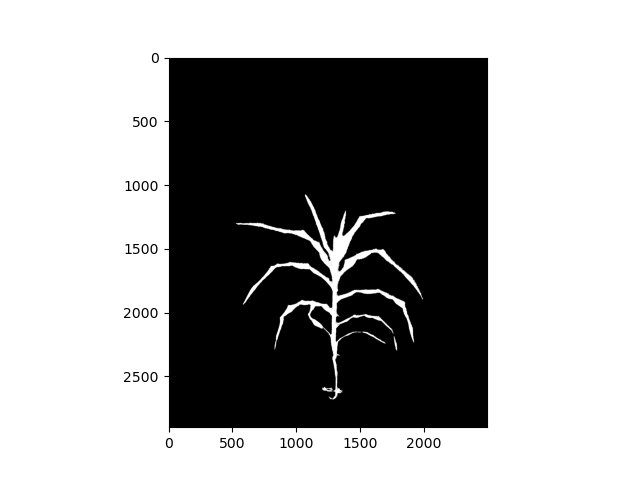

In [19]:
# Inputs:
#    mask - the clean mask you made above
#    roi - the region of interest you specified above
#    roi_type - 'partial' (default, for partially inside the ROI), 'cutto', or 'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=fill_mask, roi=roi, roi_type='partial')

# Analysis

Analyze shape and color. The data gets stored to an Outputs class automatically.

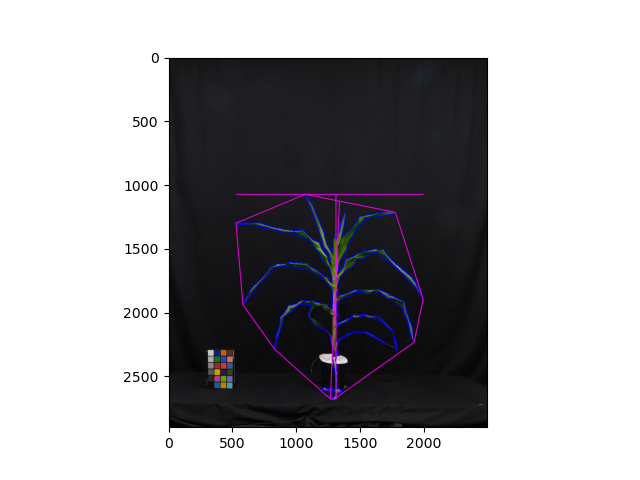

In [20]:
# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=crop_img, labeled_mask=kept_mask)

In [21]:
# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=crop_img, labeled_mask=kept_mask, colorspaces='all', label="default")

alt.FacetChart(...)

# Save Results
The path to your results was set above in the inputs/outputs section.

In [23]:
#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename= args.result)